## Initial Setup

In [1]:
# Turn on inline display of plots in the notebook. (We should work on a more
# portable solution such as saving th plots to files down the road.)
%matplotlib inline

In [ ]:
import pyodbc

#### Create a connection function

In [2]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;') # Windows auth
        return connection
    except:
        return 1 # could not connect

In [3]:
import pandas as pd

## Load all historical data from DB w/ SQL

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

In [6]:
# Select [EndTimeStamp] to mark the day, [Duration], from [Request] union with [Request_History] w/ SQL:
from_req = 'SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request]'
union = ' UNION ALL'
from_req_hist = ' SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request_History]'
sql = from_req + union + from_req_hist
all_requests = pd.read_sql(sql, reporting_conn, index_col='StartTimeStamp')

**all_requests** is the basis DataFrame that we will use to create other DFs from later...

In [7]:
type(all_requests) is pd.DataFrame

True

#### First look at all_requests DF

In [8]:
all_requests.describe()

,Duration
count,7.698000e+03
mean,3.034096e+02
std,2.485370e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.178484e+06


In [9]:
all_requests.isna().sum()

Duration    127
dtype: int64

#### Add some useful columns to all_requests

In [10]:
all_requests['Year'] = all_requests.index.year
all_requests['Month'] = all_requests.index.month
all_requests['Week'] = all_requests.index.week
all_requests['Weekday'] = all_requests.index.weekday_name
all_requests['Day'] = all_requests.index.day
all_requests = all_requests.dropna()
all_requests.head()

,Duration,Year,Month,Week,Weekday,Day
StartTimeStamp,,,,,,
2015-05-30 21:23:56.030,0.0,2015,5,22,Saturday,30
2015-05-30 23:36:55.653,12.0,2015,5,22,Saturday,30
2015-05-30 23:38:25.200,13.0,2015,5,22,Saturday,30
2015-05-30 23:44:01.490,9.0,2015,5,22,Saturday,30
2015-05-30 23:51:05.340,8.0,2015,5,22,Saturday,30


#### Drop the weekends from all_requests

Comment out the following code to include weekends in all code that uses all_requests or it's children DFs:

In [11]:
weekday_filter = ( (all_requests['Weekday'] != 'Saturday') & (all_requests['Weekday'] != 'Sunday') )
all_requests.where(weekday_filter, inplace=True)
all_requests.dropna(inplace=True)

## Initial Seaborn visualizations/mock ups

In [12]:
import seaborn as sns

#### Daily max request durations by weekday

NOTE: daily_max_request below is aggregating each distinct **day value** only. so 07/18/2015 and 06/18/2016 will be aggregated together...

In [13]:
# Create daily_max_request DF by grouping by day and aggregating the max:
daily_max_request = all_requests.groupby('Day').max()
daily_max_request = daily_max_request.rename(columns={'Duration':'Max_Duration'})
daily_max_request.head()

,Max_Duration,Year,Month,Week,Weekday
Day,,,,,
2.0,9.0,2015.0,2.0,6.0,Monday
3.0,40.0,2015.0,2.0,6.0,Tuesday
4.0,1.0,2015.0,2.0,6.0,Wednesday
5.0,187.0,2015.0,6.0,23.0,Thursday
6.0,2.0,2015.0,10.0,41.0,Tuesday


In [14]:
# Check how many unique day values there are in all_requests (to verify our result above):
all_requests['Day'].nunique()

29

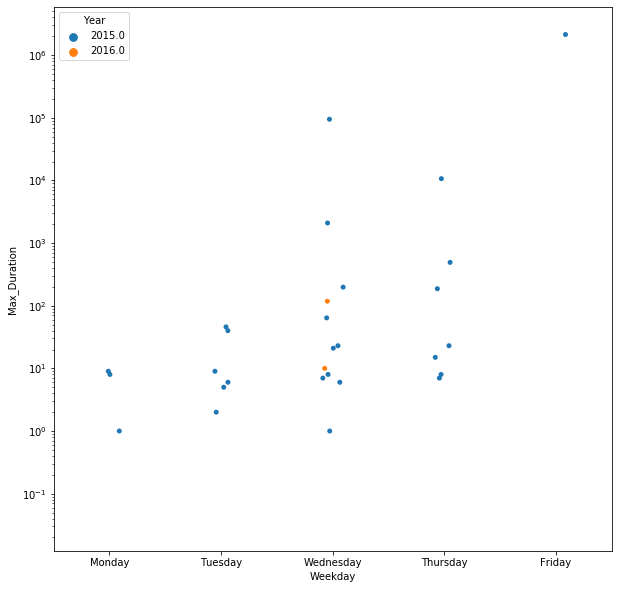

<Figure size 432x288 with 0 Axes>

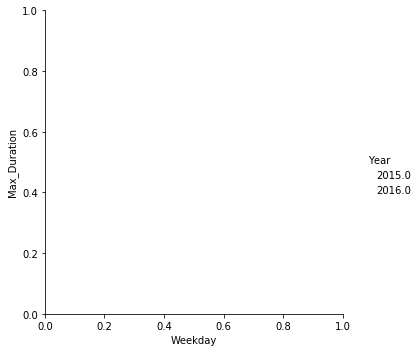

In [15]:
#--- Why do we have two graphs showing up here?
fig, ax = plt.subplots(figsize=(10,10))
plt.figure()
ax.set(yscale='log')
p = sns.catplot(x='Weekday', y='Max_Duration', hue='Year', data=daily_max_request, ax=ax)
plt.show()

# Day of the month instead of week, exclude sat/sun. Should see a pattern of spikes for first 7 day of the month.

# Add another variable, count of durations. Plot with amount of calls, overlay durations.

#### Durations by month

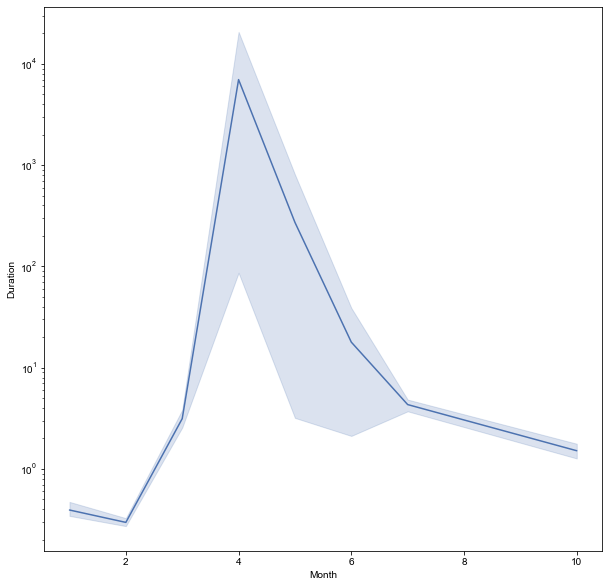

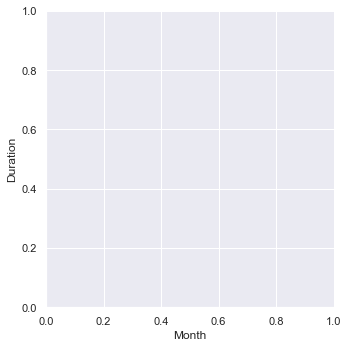

In [16]:
fig_dm, ax_dm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_dm.set(yscale='log')
sns.relplot(x='Month', y='Duration', data=all_requests, ax=ax_dm, kind='line')

#### Durations by day of the month

In [20]:
# Make labels readable. Exclude weekends. Exclude holidays? Make if very obvious that we are excluding thesedays, make this reversible.

Choose the year you would like to view request data for:

In [36]:
year = 2015

In [40]:
year_filter = ( all_requests['Year'] == year )
all_requests_for_year = all_requests.where(year_filter)
all_requests_for_year.dropna(inplace=True)
# all_requests_for_year.head()

Instead of breaking up the dataframe into 12 dataframes for each month, let's use FacetGrid...

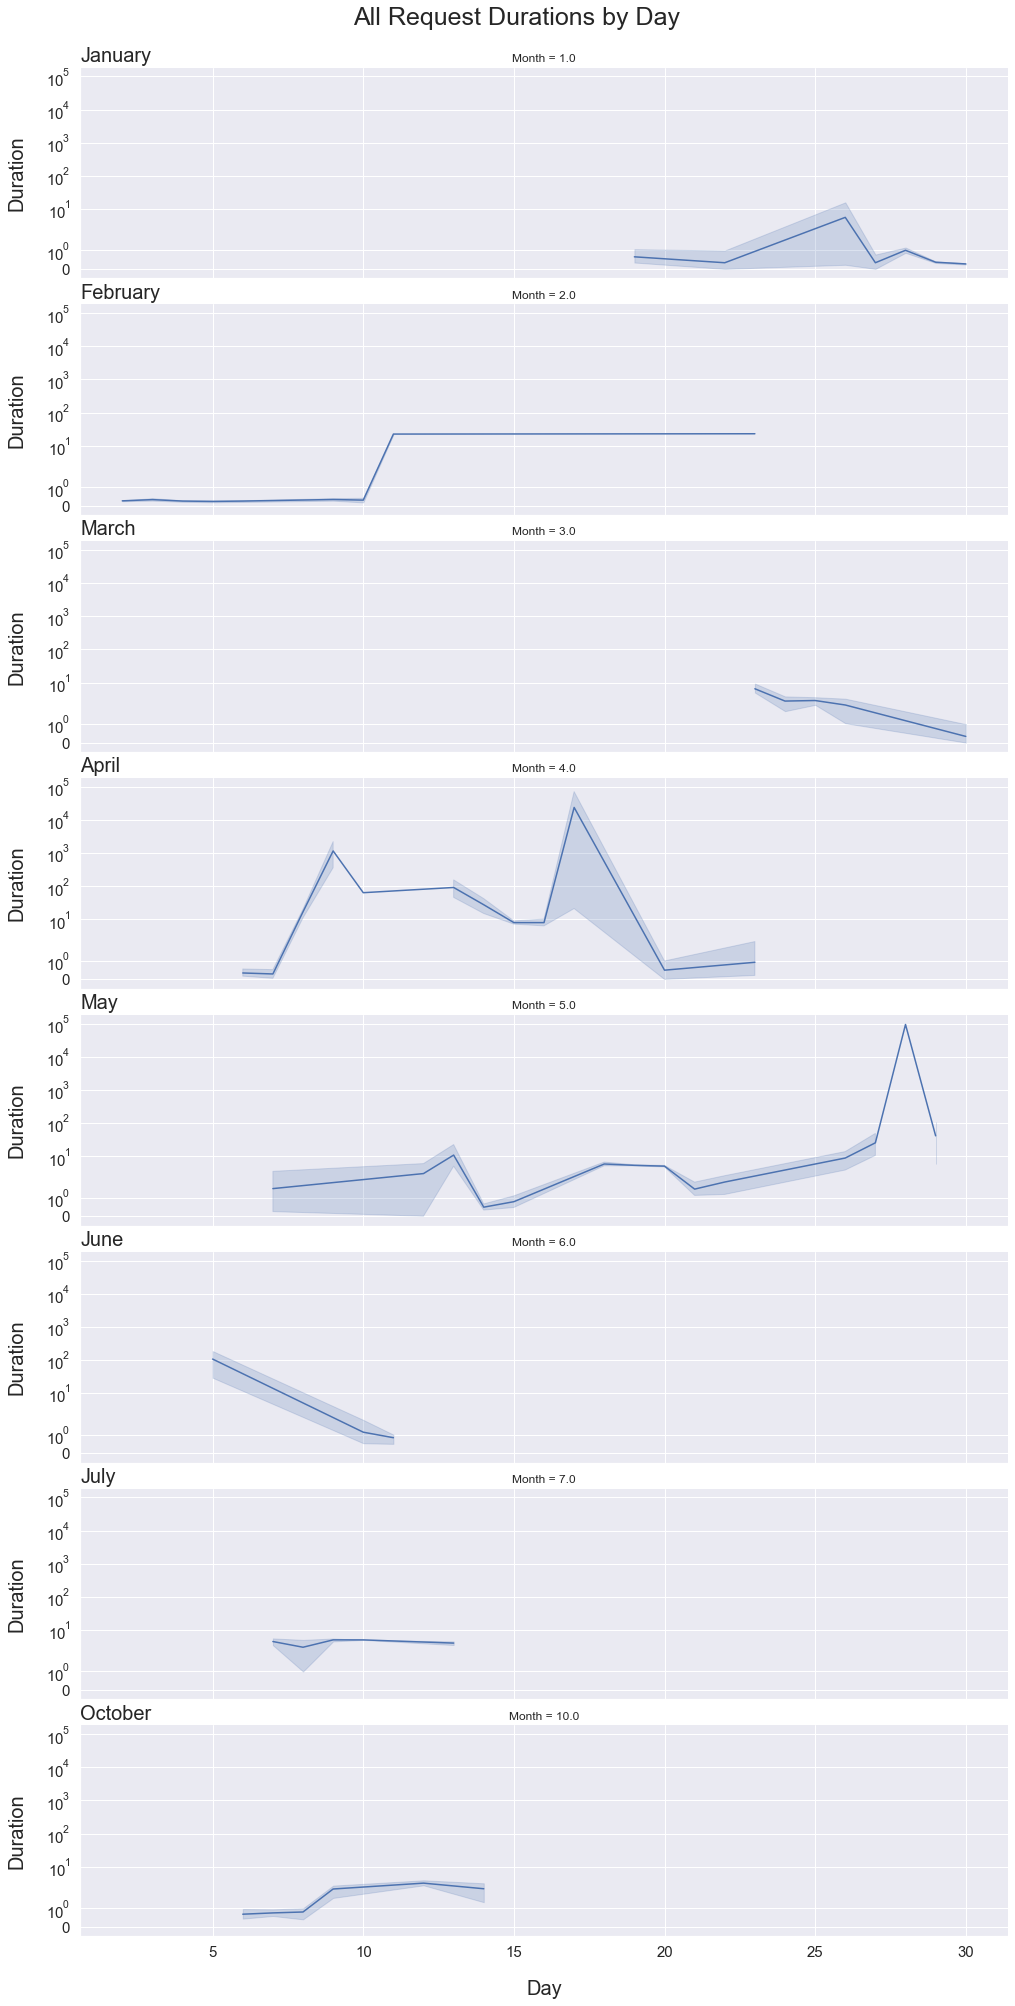

In [54]:
month_grid = sns.FacetGrid(all_requests_for_year, row='Month', height=3.5, aspect=4)
month_grid.map(sns.lineplot, 'Day', 'Duration')

# Set aesthetics:
plt.subplots_adjust(top=0.95)
month_grid.fig.suptitle('All Request Durations by Day', fontsize=25)

month_grid.set_ylabels('Duration', fontsize=20, labelpad=15)
month_grid.set_xlabels('Day', fontsize=20, labelpad=15)

axes = month_grid.axes.flatten() # Numpy flatten 2D array of axes to array or 1D rows.
# Create a dict of name-number pairs for month labeling:
month_number_name = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}
for month in range(len(axes)):
    # Extract the two characters that will contain the number:
    this_month_str = (axes[month].get_title())[-4] + (axes[month].get_title())[-3]
    # If the letter at position -4 from get_title() is a space, then it must have been a single-digit number in the name,
    # so extract it:
    if this_month_str[0] == ' ':
        this_month_number = int(this_month_str[1])
    else:
        this_month_number = int(this_month_str)
    # Change the title to the correct month name from the dict:
    axes[month].set_title(month_number_name[this_month_number], loc='left', fontsize=20) # Weird behavior
    
month_grid.set(yscale='symlog')  # Retain zero values
# ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

for i in range(len(axes)):
    axes[i].tick_params(axis='both', which='major', labelsize=15)


# month_grid.set_xticklabels('')


As opposed to **this**:

In [17]:
# Hanlde these errors. Handle errors for nulls in all of the code.

In [18]:
grouped_months = all_requests.groupby('Month')
# for name, group in grouped_months:
#     print(name)
#     print(group)

# Some months have no data, exclude these:
all_requests_jan = grouped_months.get_group(1)
all_requests_feb = grouped_months.get_group(2)
all_requests_mar = grouped_months.get_group(3)
all_requests_apr = grouped_months.get_group(4)
all_requests_may = grouped_months.get_group(5)
all_requests_jun = grouped_months.get_group(6)
all_requests_jul = grouped_months.get_group(7)
#all_requests_aug = grouped_months.get_group(8)
# all_requests_sep = grouped_months.get_group(9)
all_requests_oct = grouped_months.get_group(10)
# all_requests_nov = grouped_months.get_group(11)
# all_requests_dec = grouped_months.get_group(12)

In [ ]:
#--- Make this more concise?
fig_months, axes = plt.subplots(12, 1, figsize=(25,30), sharex='all')
sns.lineplot(x='Day', y='Duration', data=all_requests_jan, ax=axes[0]).set(title="January")
sns.lineplot(x='Day', y='Duration', data=all_requests_feb, ax=axes[1])
sns.lineplot(x='Day', y='Duration', data=all_requests_mar, ax=axes[2])
sns.lineplot(x='Day', y='Duration', data=all_requests_apr, ax=axes[3])
sns.lineplot(x='Day', y='Duration', data=all_requests_may, ax=axes[4])
sns.lineplot(x='Day', y='Duration', data=all_requests_jun, ax=axes[5])
sns.lineplot(x='Day', y='Duration', data=all_requests_jul, ax=axes[6])
#sns.lineplot(x='Day', y='Duration', data=all_requests_aug, ax=axes[7])
#sns.lineplot(x='Day', y='Duration', data=all_requests_sep, ax=axes[8])
sns.lineplot(x='Day', y='Duration', data=all_requests_oct, ax=axes[9])
#sns.lineplot(x='Day', y='Duration', data=all_requests_nov, ax=axes[10])
#sns.lineplot(x='Day', y='Duration', data=all_requests_dec, ax=axes[11])`

#### Durations by month

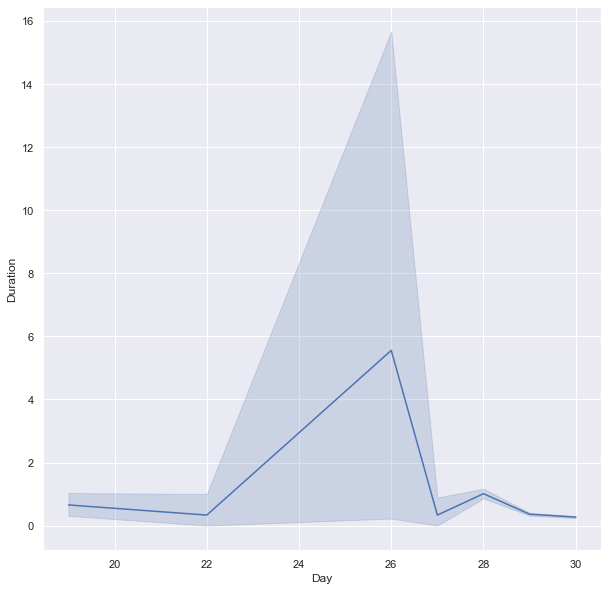

<Figure size 432x288 with 0 Axes>

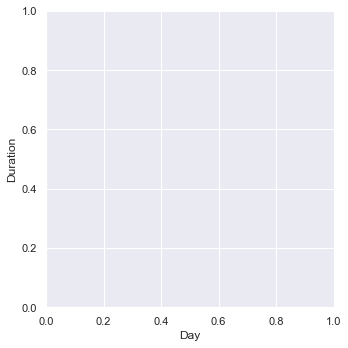

In [19]:
fig_j, ax_j = plt.subplots(figsize=(10,10))
plt.figure()
sns.set(style='darkgrid')
sns.relplot(x='Day', y='Duration', data=all_requests_jan, ax=ax_j, kind='line')

#### Min/max request dur. per week vs. request load per day

Create new DF with total requests per day:

In [23]:
# Modify this to . Don't necessarily care about days. Collapse into 5 day (M=F) increments and repeat these over each month.
# Summarize average request time but overlay min and max/outliers.
# Use log scale with infinite deviation (for requests so long that something is wrong with the server)/cutoff point for extreme outliers.
# Three months of data for week view. Maybe month-by-month for 2 years. Total health history for all data.
# Make these time variables easy to modify by new users of this notebook.

# We will be giving this to clients. This will be a way to diagnose issues. This notebook will be logs, there wil be another for troubleshooting server issues.

# Might be able to get new data to test (WCN has 5 yrs).

# Prefer mean over average.

In [10]:
daily_request_count = all_requests.resample('D').count()
daily_request_count['Month'] = daily_request_count.index.month
daily_request_count['Weekday'] = daily_request_count.index.weekday_name
daily_request_count = daily_request_count.dropna()
daily_request_count = daily_request_count.rename(columns={'Duration':'Duration_Count'})
daily_request_count.head()

,Duration_Count,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-01-19,29,29,1,29,29,Monday
2015-01-20,0,0,1,0,0,Tuesday
2015-01-21,0,0,1,0,0,Wednesday
2015-01-22,3,3,1,3,3,Thursday
2015-01-23,0,0,1,0,0,Friday


Create DF with maxes/mins per week:

In [11]:
# First get maxes into a new DF with week downsample:
request_max_wk = all_requests.resample('W').max()
#request_max_wk = request_max_wk.rename(columns={'Duration':'Max_Duration'})

# Then get mins into a new DF:
# request_min_wk = all_requests.resample('W').min()
# request_min_wk = request_min_wk.rename(columns={'Duration':'Min_Duration'})

# Create an outliers DF with both max and min:
request_outliers_wk = all_requests.resample('W').min()
request_outliers_wk['Weekday'] = request_outliers_wk.index.weekday_name
request_outliers_wk['Max_Duration'] = request_max_wk['Duration']
request_outliers_wk = request_outliers_wk.rename(columns={'Duration':'Min_Duration'})
request_outliers_wk = request_outliers_wk.dropna()
request_outliers_wk.head()

,Min_Duration,Year,Month,Week,Day,Weekday,Max_Duration
StartTimeStamp,,,,,,,
2015-01-25,0.0,2015.0,1.0,4.0,19.0,Sunday,4.0
2015-02-01,0.0,2015.0,1.0,5.0,1.0,Sunday,46.0
2015-02-08,0.0,2015.0,2.0,6.0,2.0,Sunday,40.0
2015-02-15,0.0,2015.0,2.0,7.0,9.0,Sunday,23.0
2015-03-01,23.0,2015.0,2.0,9.0,23.0,Sunday,23.0


## 3-month historical log for M-F weeks

#### Definitions

Consider eliminating months that we don't need in sql...

In [11]:
# Definitons:
start_month = 1
end_month = 3
year = 2015

#### Data prep

Select only the months and year specified

In [12]:
month_filter = ( (all_requests['Month'] >= start_month) & (all_requests['Month'] <= end_month) & (all_requests['Year'] == year) ) # Boolean series
history_3_mon = all_requests.where(month_filter)
history_3_mon = history_3_mon.dropna()
history_3_mon.head()

,Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-01-19 02:13:37.180,0.0,2015.0,1.0,4.0,19.0
2015-01-19 02:13:51.380,0.0,2015.0,1.0,4.0,19.0
2015-01-19 02:14:02.283,0.0,2015.0,1.0,4.0,19.0
2015-01-19 02:14:09.700,0.0,2015.0,1.0,4.0,19.0
2015-01-19 02:17:25.843,1.0,2015.0,1.0,4.0,19.0


Drop Sunday and Saturday:

In [13]:
# Add Weekday col:
history_3_mon['Weekday'] = history_3_mon.index.weekday_name

weekday_filter = ( (history_3_mon['Weekday'] != 'Saturday') & (history_3_mon['Weekday'] != 'Sunday') )
history_3_mon = history_3_mon.where(weekday_filter)
history_3_mon = history_3_mon.dropna()
history_3_mon.head()

,Duration,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-01-19 02:13:37.180,0.0,2015.0,1.0,4.0,19.0,Monday
2015-01-19 02:13:51.380,0.0,2015.0,1.0,4.0,19.0,Monday
2015-01-19 02:14:02.283,0.0,2015.0,1.0,4.0,19.0,Monday
2015-01-19 02:14:09.700,0.0,2015.0,1.0,4.0,19.0,Monday
2015-01-19 02:17:25.843,1.0,2015.0,1.0,4.0,19.0,Monday


Find mins/maxes for weeks:

In [31]:
# Pull out only the data we need from all_requests here:
# all_request_durs = all_requests['Duration']
# all_request_durs['Weekday'] = all_requests.index.weekday_name
# all_request_durs.head()

#### 3-month historical stats by WEEK

##### Create 2 DFs, one w/ *most* aggs. for the week, one preserving other columns, then join

Idea for this approach:

In [32]:
# Need to preserve just the Week by using it as an index, then make another aggregated dataframe by week with
# all the columns then merge them on Week number.

1st DF - all aggregations by week that we need to do (except for mean)...

In [14]:
week_aggs = history_3_mon.groupby('Week', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
    Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
#     Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count'),
    First_Day=pd.NamedAgg(column='Day', aggfunc='min'),
    Last_Day=pd.NamedAgg(column='Day', aggfunc='max')
#     Weekday=pd.NamedAgg(column='Duration', aggfunc=np.first)
)
week_aggs

,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day
Week,,,,,
4.0,0.0,4.0,32,19.0,22.0
5.0,0.0,46.0,1474,26.0,30.0
6.0,0.0,40.0,4325,2.0,6.0
7.0,0.0,23.0,438,9.0,11.0
9.0,23.0,23.0,1,23.0,23.0
13.0,0.0,22.0,87,23.0,26.0
14.0,0.0,1.0,3,30.0,30.0


2nd DF - one aggregation w/ df.groupby() to preserve other columns:

In [16]:
# Downsample history_3_mon to keep its datetime index
week_agg_mean = history_3_mon.groupby('Week', as_index=True).mean()
week_agg_mean = week_agg_mean.rename(columns={'Duration':'Mean_Duration'})
week_agg_mean.dropna(inplace=True) # use this form elsewhere!
week_agg_mean

,Mean_Duration,Year,Month,Day
Week,,,,
4.0,0.625000,2015.0,1.0,19.281250
5.0,0.388060,2015.0,1.0,29.409091
6.0,0.277457,2015.0,2.0,3.005318
7.0,0.433790,2015.0,2.0,9.136986
9.0,23.000000,2015.0,2.0,23.000000
13.0,3.183908,2015.0,3.0,24.747126
14.0,0.333333,2015.0,3.0,30.000000


Join the two

In [22]:
dur_stats_3_mon_by_wk = pd.merge(week_aggs, week_agg_mean, on='Week')
# Add a "Year-Month" column that can be used as a label for the plot, describing the month and the day-range of the given week:
dur_stats_3_mon_by_wk['Year-Month'] = dur_stats_3_mon_by_wk['Year'].astype(int).astype(str) + '/' + dur_stats_3_mon_by_wk['Month'].astype(int).astype(str) + '\ndays: ' + dur_stats_3_mon_by_wk['First_Day'].astype(int).astype(str) + '-' + dur_stats_3_mon_by_wk['Last_Day'].astype(int).astype(str)
dur_stats_3_mon_by_wk

,Min_Duration,Max_Duration,Count_Durations,First_Day,Last_Day,Mean_Duration,Year,Month,Day,Year-Month
Week,,,,,,,,,,
4.0,0.0,4.0,32,19.0,22.0,0.625000,2015.0,1.0,19.281250,2015/1\ndays: 19-22
5.0,0.0,46.0,1474,26.0,30.0,0.388060,2015.0,1.0,29.409091,2015/1\ndays: 26-30
6.0,0.0,40.0,4325,2.0,6.0,0.277457,2015.0,2.0,3.005318,2015/2\ndays: 2-6
7.0,0.0,23.0,438,9.0,11.0,0.433790,2015.0,2.0,9.136986,2015/2\ndays: 9-11
9.0,23.0,23.0,1,23.0,23.0,23.000000,2015.0,2.0,23.000000,2015/2\ndays: 23-23
13.0,0.0,22.0,87,23.0,26.0,3.183908,2015.0,3.0,24.747126,2015/3\ndays: 23-26
14.0,0.0,1.0,3,30.0,30.0,0.333333,2015.0,3.0,30.000000,2015/3\ndays: 30-30


finally...

#### Convert to long-form to use categorical functionality of sns.swarmplot

In [24]:
# Unpivot:
longform_dur_stats_3_mon_by_wk = pd.melt(dur_stats_3_mon_by_wk, id_vars='Week', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
# longform_dur_stats_3_mon_by_wk = pd.merge(longform_dur_stats_3_mon_by_wk, dur_stats_3_mon_by_wk, how='left', on='Week') # Clean this up to only bring in columns we need.
# longform_dur_stats_3_mon_by_wk.drop(axis=1, columns=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations', 'Year', 'Month', 'Day'])
longform_dur_stats_3_mon_by_wk.head()

,Week,Dur_Stat_Type,Dur_Stat_Value
0,NaN,Min_Duration,0.0
1,NaN,Min_Duration,0.0
2,NaN,Min_Duration,0.0
3,NaN,Min_Duration,0.0
4,NaN,Min_Duration,23.0


#### Plots of stats for 3 months, by week

In [67]:
import seaborn as sns

##### Swarmplot of min, max, mean, count w/ lin-reg fit

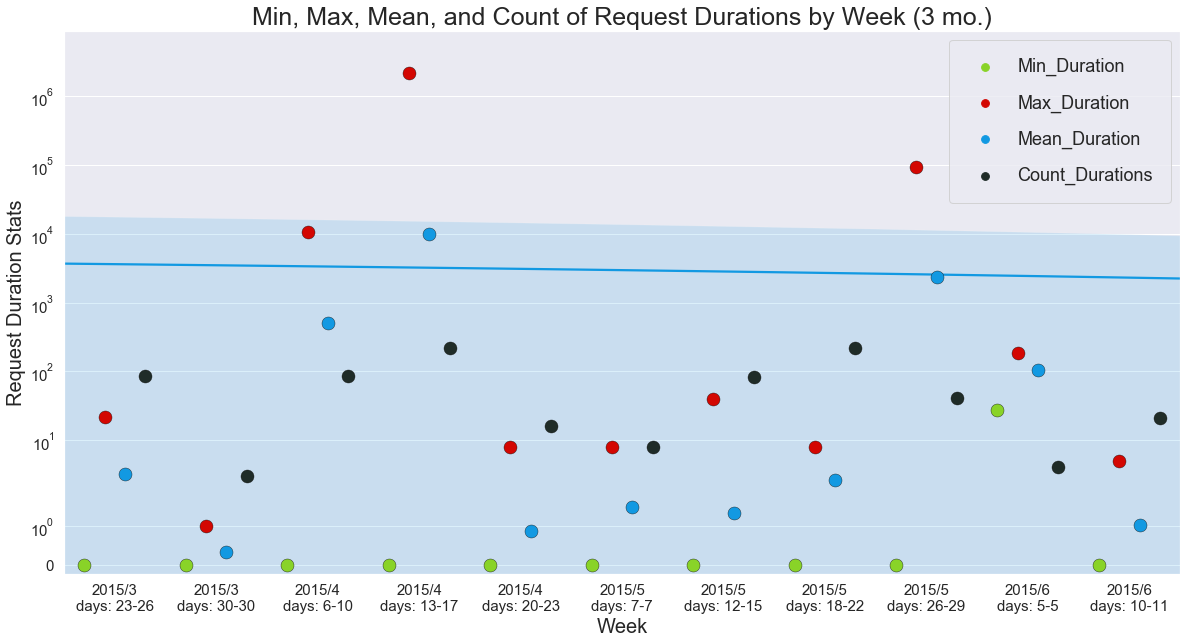

In [72]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

colors = sns.color_palette(('#89D328', '#D30702', '#1299E2', '#1F2C28'))  # MIN, MAX, MEAN, COUNT

sns.swarmplot(x='Week', y='Dur_Stat_Value', hue='Dur_Stat_Type', data=longform_dur_stats_3_mon_by_wk, dodge=True, edgecolor='gray', linewidth=.4, palette=colors, s=13, ax=ax)
sns.regplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, color='#1299E2', scatter_kws={'s': 0}, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Week', fontsize=20)
ax.set_title('Min, Max, Mean, and Count of Request Durations by Week (3 mo.)', loc='center', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(longform_dur_stats_3_mon_by_wk['Year-Month'])

ax.legend(borderpad=1, labelspacing=1, fontsize=18)

##### Lineplot of MEAN, with counts for each week

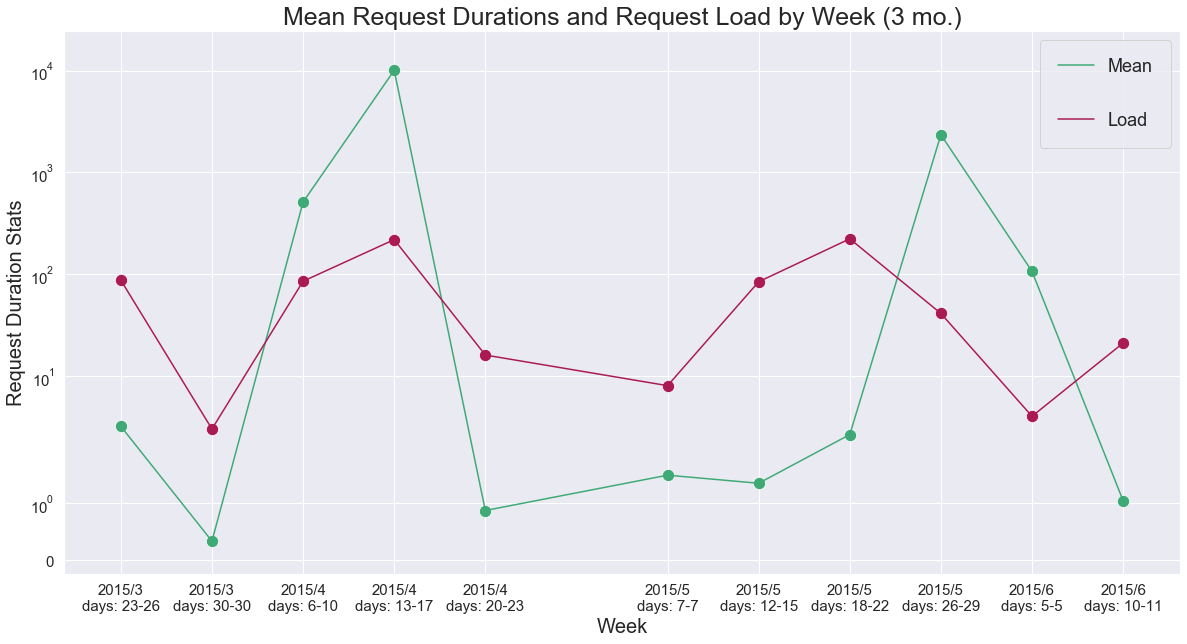

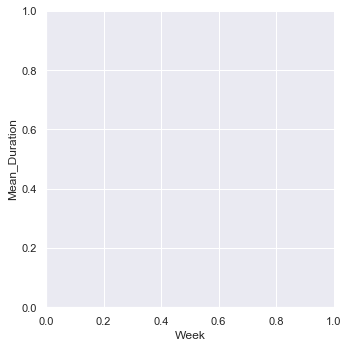

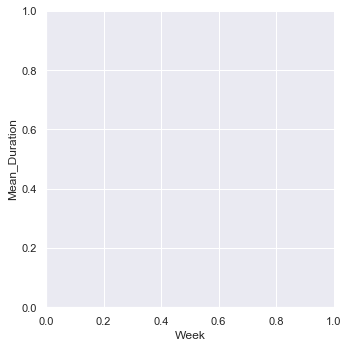

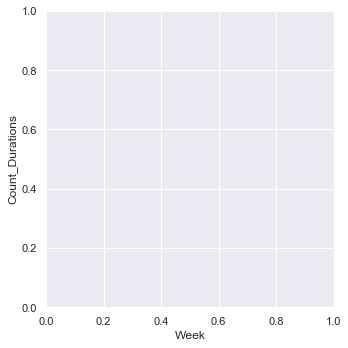

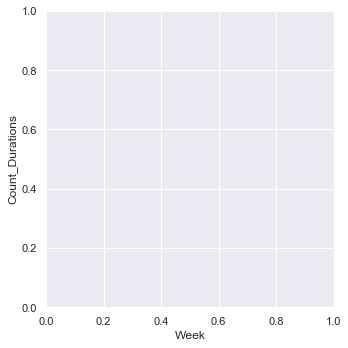

In [141]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

# nice green: #3FAA75
sns.relplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, kind='line', color='#3FAA75', ax=ax)
sns.relplot(x='Week', y='Mean_Duration', data=dur_stats_3_mon_by_wk, kind='scatter', color='#3FAA75', s=150, ax=ax)
sns.relplot(x='Week', y='Count_Durations', data=dur_stats_3_mon_by_wk, kind='line', color='#AB1B53', ax=ax)
sns.relplot(x='Week', y='Count_Durations', data=dur_stats_3_mon_by_wk, kind='scatter', color='#AB1B53', s=150, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Week', fontsize=20)

ax.set_title('Mean Request Durations and Request Load by Week (3 mo.)', loc='center', fontsize=25)

ax.set_xticks(dur_stats_3_mon_by_wk['Week'])
ax.set_xticklabels(longform_dur_stats_3_mon_by_wk['Year-Month'])
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(('Mean', 'Load'), borderpad=1, labelspacing=2, fontsize=18)

#### 3-month historical stats by DAY

In [166]:
day_aggs = history_3_mon.groupby('Day', as_index=True).agg(
    Min_Duration=pd.NamedAgg(column='Duration', aggfunc='min'),
#     Max_Duration=pd.NamedAgg(column='Duration', aggfunc='max'),
    Mean_Duration=pd.NamedAgg(column='Duration', aggfunc=np.mean),
    Count_Durations=pd.NamedAgg(column='Duration', aggfunc='count')
)
# day_aggs
day_aggs.head()

,Min_Duration,Mean_Duration,Count_Durations
Day,,,
2.0,0.0,0.264368,2088
3.0,0.0,0.330986,1136
4.0,0.0,0.252212,452
5.0,0.0,0.232639,288
6.0,0.0,0.252078,361


In [167]:
day_agg_max = history_3_mon.groupby('Day', as_index=True).max()
day_agg_max = day_agg_max.rename(columns={'Duration':'Max_Duration'}) # Use max so that we don't get the mean of a week...
day_agg_max.dropna(inplace=True) # use this form elsewhere!
day_agg_max.head()
# day_agg_max

,Max_Duration,Year,Month,Week,Weekday
Day,,,,,
2.0,9.0,2015.0,2.0,6.0,Monday
3.0,40.0,2015.0,2.0,6.0,Tuesday
4.0,1.0,2015.0,2.0,6.0,Wednesday
5.0,1.0,2015.0,2.0,6.0,Thursday
6.0,1.0,2015.0,2.0,6.0,Friday


In [181]:
dur_stats_3_mon_by_day = pd.merge(day_aggs, day_agg_max, on='Day')
dur_stats_3_mon_by_day

,Min_Duration,Mean_Duration,Count_Durations,Max_Duration,Year,Month,Week,Weekday
Day,,,,,,,,
2.0,0.0,0.264368,2088,9.0,2015.0,2.0,6.0,Monday
3.0,0.0,0.330986,1136,40.0,2015.0,2.0,6.0,Tuesday
4.0,0.0,0.252212,452,1.0,2015.0,2.0,6.0,Wednesday
5.0,0.0,0.232639,288,1.0,2015.0,2.0,6.0,Thursday
6.0,0.0,0.252078,361,1.0,2015.0,2.0,6.0,Friday
9.0,0.0,0.336842,380,9.0,2015.0,2.0,7.0,Monday
10.0,0.0,0.303571,56,1.0,2015.0,2.0,7.0,Tuesday
11.0,22.0,22.500000,2,23.0,2015.0,2.0,7.0,Wednesday
19.0,0.0,0.655172,29,4.0,2015.0,1.0,4.0,Monday


##### Get exactly/only the data we need

In [169]:
longform_dur_stats_3_mon_by_day = pd.melt(dur_stats_3_mon_by_day.reset_index(), id_vars='Day', value_vars=['Min_Duration', 'Max_Duration', 'Mean_Duration', 'Count_Durations'], var_name='Dur_Stat_Type', value_name='Dur_Stat_Value')
# longform_dur_stats_3_mon_by_day.set_index(keys='Day', inplace=True) # duplicate keys OK!

# Get Date and Weekday from hist_3_mon:
# Is there a better way to get the time stamp?
hist_3_mon_day_index = history_3_mon.reset_index().set_index(keys='Day')
hist_3_mon_day_index = hist_3_mon_day_index.groupby('Day').max()
hist_3_mon_day_index['StartTimeStamp'] = hist_3_mon_day_index['StartTimeStamp'].astype(str).str.split(' ', expand=True)[0]
hist_3_mon_day_index = hist_3_mon_day_index[['StartTimeStamp', 'Weekday', 'Month']]
hist_3_mon_day_index.head()
# longform_dur_stats_3_mon_by_day

,StartTimeStamp,Weekday,Month
Day,,,
2.0,2015-02-02,Monday,2.0
3.0,2015-02-03,Tuesday,2.0
4.0,2015-02-04,Wednesday,2.0
5.0,2015-02-05,Thursday,2.0
6.0,2015-02-06,Friday,2.0


##### Put data from above into it's own DF for swarmplot

In [170]:
longform_dur_stats_3_mon_by_day = pd.merge(longform_dur_stats_3_mon_by_day, hist_3_mon_day_index, how='left', on='Day')

In [ ]:
longform_dur_stats_3_mon_by_day['Day_Label'] = longform_dur_stats_3_mon_by_day['StartTimeStamp'].astype(str) + ' \n' + longform_dur_stats_3_mon_by_day['Weekday'].astype(str)
longform_dur_stats_3_mon_by_day.set_index(keys='Day', inplace=True)
longform_dur_stats_3_mon_by_day.drop(axis=1, columns=['StartTimeStamp', 'Weekday'], inplace=True)

In [ ]:
longform_dur_stats_3_mon_by_day.head()

##### Swarmplot of stats by day

Break up into 3 months..?

In [172]:
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,10))

colors = sns.color_palette(('#89D328', '#D30702', '#1299E2', '#1F2C28'))  # MIN, MAX, MEAN, COUNT

sns.swarmplot(x=longform_dur_stats_3_mon_by_day.index, y='Dur_Stat_Value', hue='Dur_Stat_Type', data=longform_dur_stats_3_mon_by_day, dodge=True, edgecolor='gray', linewidth=.4, palette=colors, s=7, ax=ax)
# sns.regplot(x='Day', y='Mean_Duration', data=dur_stats_3_mon_by_day, color='#1299E2', scatter_kws={'s': 0}, ax=ax)

ax.set_yscale('symlog')  # Retain zero values
ax.set_ylim(bottom=-0.25)  # 0 doesn't work... 

ax.set_ylabel('Request Duration Stats', fontsize=20)
ax.set_xlabel('Day', fontsize=20)
ax.set_title('Min, Max, Mean, and Count of Request Durations by Week (3 mo.)', loc='center', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(longform_dur_stats_3_mon_by_day['Day_Label'])

ax.legend(borderpad=1, labelspacing=1, fontsize=18)

Initialize the FacetGrid object which will be plotted on later

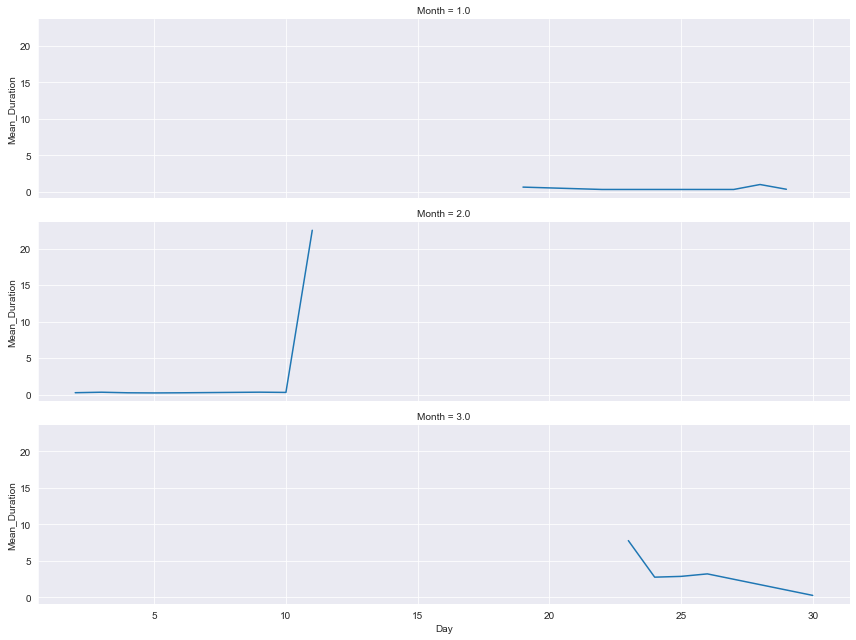

In [180]:
grid = sns.FacetGrid(row='Month', data=dur_stats_3_mon_by_day.reset_index(), height=3, aspect=4)

grid.map(sns.lineplot, 'Day', 'Mean_Duration')